A figura abaixo apresenta um diagrama do método TTS

<p align="center">

<img src=".\Figures\tts.png" alt="Diagrama do método Transition Tube Sampling" style="width:600px;"/>

</p>

De forma geral, este método parte de um caminho de reação, como descrito no quadro A da figura. Este caminho de reação pode ser obtido através de métodos como o NEB, porém fornecendo apenas pontos discretos, como os que estão representados no quadro B, sendo estas as geometrias de controle.

O que o método TTS é responsável por fazer é interpolar as coordenadas das estruturas de controle, buscando assim obter uma malha contínua de coordenadas que pertençam a esse caminho de reação. A interpolação destas coordenadas é então utilizada para gerar novas estruturas que também pertençam ao caminho de reação, permitindo assim a obtenção das geometrias de referência, representadas no quadro C.

Os pontos da interpolação que serão utilizados para gerar as geometrias de referência são amostrados a partir da seguinte densidade de probabilidade (gráfico do quadro E) em relação a coordenada de reação:

$$ p_c (\xi) = \begin{cases} \sin^2 \left[ \frac{\pi}{2|\xi_c - \xi_{c-1}|} (\xi - \xi_{c-1}) \right], \xi_{c-1} \leq \xi \leq \xi_c \\ \cos^2 \left[ \frac{\pi}{2|\xi_c - \xi_{c+1}|} (\xi - \xi_c) \right], \xi_c \leq \xi \leq \xi_{c+1} \\ 0 \text{ caso contrário} \\ \end{cases} $$

Uma vez amostradas as geometrias de referência, o próximo passo é realizar a expansão de modos normais das configurações amostradas. A expansão de modos normais pode ser realizada tanto através de uma distribuição clássica, onde não há NQE, quanto de uma distribuição que inclua NQE. A distribuição clássica é dada a partir da seguinte equação:

$$ \rho_{c} (\Omega_{1}, \, ..., \, \Omega_{N_{int}}) \alpha \prod_{i = 1}^{N_{int}} \exp \left[ - \frac{1}{2} \beta \omega_{i}^{2} \Omega_{i}^{2} \right] $$

Já a distribuição que inclui NQE possui é escrita como:

$$ \beta^{*} (\beta, \omega) = \frac{2}{\hbar \omega} \tanh \left( \frac{\beta \hbar \omega}{2} \right); $$

$$ \rho_{q} (\Omega_{1}, \, ..., \, \Omega{N_{int}} ) \alpha \prod_{i = 1}^{N_{int}} \exp \left[ -\frac{1}{2} \beta^{*} (\beta, \omega_{i}) \omega_{i}^{2} \Omega{i}^{2} \right] $$

A partir destas distribuições são sorteados valores aleatórios que serão utilizados como pesos na expansão em modos normais. A expansão é realizada de acordo com a seguinte equação:

$$ \vec{R} = \vec{R}_{0} + \mathbb{M}^{-1 / 2} \sum_{i} \Omega_{c, i} \left[ \mathbb{I} - \mathbb{P} (\xi) \right] \vec{\Omega_{c, i}} $$

Onde a matriz $P(\xi)$ é utilizada para segurar que as configurações geradas através da expansão são ortogonais ao caminho de reação. Essa matriz é definida como:

$$ P(\xi) =
    \begin{pmatrix}
        \frac{d x_{O} (\xi)}{d \xi} & \frac{d y_{O} (\xi)}{d \xi} & \frac{d z_{O} (\xi)}{d \xi} \\
        \frac{d x_{H_{1}} (\xi)}{d \xi} & \frac{d y_{H_{1}} (\xi)}{d \xi} & \frac{d z_{H_{1}} (\xi)}{d \xi} \\
        \frac{d x_{H_{2}} (\xi)}{d \xi} & \frac{d y_{H_{2}} (\xi)}{d \xi} & \frac{d z_{H_{2}} (\xi)}{d \xi}
    \end{pmatrix}
$$

As geometrias geradas através da expansão de modos normais passam a configurar as geometrias candidatas (representadas no quadro D), estas que serão utilizados no treinamento do NNP.

# Imports

In [1]:
import os
import re
import ast
import random
import numpy as np
import pandas as pd
from io import StringIO
from pprint import pprint
from scipy.misc import derivative
from scipy.interpolate import interp1d

from ase import Atom, Atoms
from ase.io import read, write
from ase.visualize import view
from ase.io.trajectory import Trajectory

In [2]:
import scienceplots
import matplotlib.pyplot as plt

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE) 
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

CB_color_cycle = [
    '#377eb8',
    '#ff7f00',
    '#4daf4a',
    '#f781bf',
    '#a65628',
    '#984ea3',
    '#999999',
    '#e41a1c',
    '#dede00'
]

# Constantes e funções recorrentes

## Constantes

In [3]:
c = 299_792_458             # m/s
kB = 8.617_333_262e-5       # eV/K
h = 4.135_667_696e-15       # eV * Hz
hbar = 6.582_119_569e-16    # eV * s

## Temperatura $\beta$

In [4]:
def beta(temperature):
    beta = 1 / (kB * temperature)

    return beta

## Transformação de $cm^{-1}$ para eV dos modos normais

O ASE retorna os autovalores com unidades de $cm^{-1}$, porém é necessário fazer a transformação destes valores para eV.

In [5]:
def cm_to_ev(value):
    conversion_value = 1.23981e-4

    return value * conversion_value

## Matrizes de transformação entre coordenadas cartesianas e normais

Criei esta função para realizar a conversar entre coordenadas cartesianas e normais, entretanto acabei não utilizando no código, visto que o ASE retorna os autovalores em coordenadas cartesianas.

In [6]:
def normalMode_to_cartesian():
    matrix = np.diagflat([ 16.0000, 1.0079, 1.0079 ])
    finalMatrix = np.sqrt(np.linalg.inv(matrix))

    return finalMatrix

In [7]:
def cartesian_to_normalMode():
    matrix = np.diagflat([ 16.0000, 1.0079, 1.0079 ])
    finalMatrix = np.sqrt(matrix)

    return finalMatrix

## Escolha do funcional de troca e correlação

Aqui eu seleciono se eu irei utilizar os dados e estruturas calculadas utilizando o funcional PBE ou BH. Até o momento, toda vez que eu mudo o funcional é necessário rodar todos os blocos de código novamente

In [8]:
PBEpath = './PBE'
BHpath = './BH'

baseDir = PBEpath

if baseDir == PBEpath:
    from PBE.data.PBEdata import *

elif baseDir == BHpath:
    from BH.data.BHdata import *

# Transition Tube Sampling

## Definição dos pontos de controle e da malha de pontos da interpolação

Aqui são definidos os pontos da coordenada de reação, tanto os do NEB (que no caso são 5) quanto os pontos da interpolação (decidi fazer uma malha com 1000 pontos para a interpolação). Ambos estão definidos entre 0 e 1.

In [9]:
qsi = np.linspace(0, 1, num=5)
qsiInterpolation = np.linspace(0, 1, 1000)

## Definindo os dados do NEB

A função *get_neb* apresentada abaixo retorna tanto os dados (energias, autovalores e autovetores) quanto as geometrias das estruturas do NEB.

Já a função *get_water_indexes* foi criada para definir os índices dos átomos da molécula de água nas estruturas do NEB, somente para facilitar, uma vez que estes índices serão utilizados com frequência.

In [10]:
def get_neb():
    nebFiles = [ neb_initial, neb_image_1, neb_image_2, neb_image_3, neb_final ]
    nebData = [ get_system_data(system) for system in nebFiles ]
    nebStructures = [ read(f'{baseDir}/{system[0]}.traj') for system in nebData ]

    return nebData, nebStructures

In [11]:
def get_water_indexes():
    neb = get_neb()
    oxygenIndex = [atom.index for atom in neb[1][0] if atom.symbol == 'O'][0]
    hydrogen2Index = [atom.index for atom in neb[1][0] if atom.symbol == 'H'][1]
    waterAtoms = range(oxygenIndex, hydrogen2Index + 1)

    return waterAtoms

## Interpolação das coordenadas do NEB

A função *separate_atoms_coordinates* realiza a separação das coordenadas (x, y, z) de cada átomo das estruturas do NEB, retornando uma lista contendo essas posições. Os dados foram tratados para que ficassem na ordem da interpolação.

Já a função *interpolate_neb* realiza a interpolação de fato das coordenadas. Para isso foi utilizado a função *interp1d* do módulo scipy, utilizando uma interpolação cúbica. Esta função retorna os pontos da interpolação de cada coordenada para cada átomo.

In [12]:
def separate_atoms_coordinates():
    '''
    Essa função retorna uma lista [0:3], onde cada elemento corresponde as posições (x, y, z) de cada átomo no sistema monômero + Au(111), para cada estrutura do NEB

    O vetor neb é estruturado da seguinte forma:
    - Primeiro índice: Estrutura do neb [0, 5]
    - Segundo índice: Seleciona o átomo [0, 67]
    - Terceiro índice: Seleciona a coordenada (x, y, z) [0, 3]
    '''

    neb = get_neb()

    xPositions = np.array([ [ neb[1][i].positions[j][0] for j in range(len(neb[1][0])) ] for i in range(len(neb[1])) ])
    yPositions = np.array([ [ neb[1][i].positions[j][1] for j in range(len(neb[1][0])) ] for i in range(len(neb[1])) ])
    zPositions = np.array([ [ neb[1][i].positions[j][2] for j in range(len(neb[1][0])) ] for i in range(len(neb[1])) ])

    return xPositions, yPositions, zPositions

In [13]:
def interpolate_neb(controlPointsInterpolation):
    '''
    - O vetor data é estruturado da seguinte forma:
    - Primeiro índice: Seleciona a coordenada (x, y, z) [0, 3]
    - Segundo índice: Seleciona a estrutura do NEB [0, 5]
    - Terceiro índice: Seleciona o átomo [0, 67]
    - A seguinte sintaxe: data[j][:, i], pode ser utilizada para selecionada todas as coordenadas x do primeiro átomo entre as estruturas do NEB, exatamente como é necessário na interpolação
    '''

    data = separate_atoms_coordinates()

    xInterpolation = [ interp1d(qsi, data[0][:, i], kind='cubic', fill_value='extrapolate') for i in range(len(data[0][0])) ]
    yInterpolation = [ interp1d(qsi, data[1][:, i], kind='cubic', fill_value='extrapolate') for i in range(len(data[0][0])) ]
    zInterpolation = [ interp1d(qsi, data[2][:, i], kind='cubic', fill_value='extrapolate') for i in range(len(data[0][0])) ]

    xPositionsInterpolation = np.array([ xInterpolation[i](controlPointsInterpolation) for i in range(len(xInterpolation)) ])
    yPositionsInterpolation = np.array([ yInterpolation[i](controlPointsInterpolation) for i in range(len(yInterpolation)) ])
    zPositionsInterpolation = np.array([ zInterpolation[i](controlPointsInterpolation) for i in range(len(zInterpolation)) ])

    return xPositionsInterpolation, yPositionsInterpolation, zPositionsInterpolation

## Densidade de probabilidade ao longo do TTS

$$ p_c (\xi) = \begin{cases} \sin^2 \left[ \frac{\pi}{2|\xi_c - \xi_{c-1}|} (\xi - \xi_{c-1}) \right], \xi_{c-1} \leq \xi \leq \xi_c \\ \cos^2 \left[ \frac{\pi}{2|\xi_c - \xi_{c+1}|} (\xi - \xi_c) \right], \xi_c \leq \xi \leq \xi_{c+1} \\ 0 \text{ caso contrário} \\ \end{cases} $$

A função *transition_tube_density* realiza a amostragem de probabilidade ao longo da coordenada de reação, de acordo com a função acima.

In [14]:
def transition_tube_density(controlPoints, controlPointsInterpolation):
    sinProb = lambda a, b, c : np.sin((np.pi * (a - c)) / (2 * abs(b - c))) ** 2
    # a = qsiInterpolation
    # b = qsi at controol point
    # c = qsi at controol point - 1

    cosProb = lambda a, b, c : np.cos((np.pi * (a - b)) / (2 * abs(b - c))) ** 2
    # a = qsiInterpolation
    # b = qsi at controol point
    # c = qsi at controol point + 1

    controlPoint1, controlPoint2, controlPoint3, controlPoint4, controlPoint5 = [], [], [], [], []

    for i in range(len(controlPoints)):
        for j in range(len(controlPointsInterpolation)):
            if i == 0:
                if controlPoints[i] <= controlPointsInterpolation[j] <= controlPoints[i + 1]:
                    auxVar = cosProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i + 1])
                    controlPoint1.append(auxVar)
                else:
                    controlPoint1.append(0)

            if i == 1:
                if controlPoints[i - 1] <= controlPointsInterpolation[j] <= controlPoints[i]:
                    auxVar = sinProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i - 1])
                    controlPoint2.append(auxVar)
                elif controlPoints[i] <= controlPointsInterpolation[j] <= controlPoints[i + 1]:
                    auxVar = cosProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i + 1])
                    controlPoint2.append(auxVar)
                else:
                    controlPoint2.append(0)

            if i == 2:
                if controlPoints[i - 1] <= controlPointsInterpolation[j] <= controlPoints[i]:
                    auxVar = sinProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i - 1])
                    controlPoint3.append(auxVar)
                elif controlPoints[i] <= controlPointsInterpolation[j] <= controlPoints[i + 1]:
                    auxVar = cosProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i + 1])
                    controlPoint3.append(auxVar)
                else:
                    controlPoint3.append(0)

            if i == 3:
                if controlPoints[i - 1] <= controlPointsInterpolation[j] <= controlPoints[i]:
                    auxVar = sinProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i - 1])
                    controlPoint4.append(auxVar)
                elif controlPoints[i] <= controlPointsInterpolation[j] <= controlPoints[i + 1]:
                    auxVar = cosProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i + 1])
                    controlPoint4.append(auxVar)
                else:
                    controlPoint4.append(0)

            elif i == 4:
                if controlPoints[i - 1] <= controlPointsInterpolation[j] <= controlPoints[i]:
                    auxVar = sinProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i - 1])
                    controlPoint5.append(auxVar)
                else:
                    controlPoint5.append(0)

    probabilityDistribution = [ np.array(controlPoint1), np.array(controlPoint2), np.array(controlPoint3), np.array(controlPoint4), np.array(controlPoint5) ]

    return probabilityDistribution

Já a função *get_sample_points* realiza a seleção dos pontos da densidade de probabilidade do TTS que serão utilizados para a amostragem das geometrias de referência

In [15]:
def get_sample_points(n):
    probabilityDistribution = transition_tube_density(qsi, qsiInterpolation)
    sampledPointsX = []
    sampledPointsY = []

    for i in range(n):
        selectedDistribution = random.choice(probabilityDistribution)
        selectedPoint = random.choice(selectedDistribution)

        if selectedPoint == 0:
            pass
        else:
            selectedIndex = np.where(selectedDistribution == selectedPoint)[0][0]
            sampledPointsX.append(selectedIndex)
            sampledPointsY.append(selectedPoint)

    return sorted(set(sampledPointsX)), sampledPointsY

In [16]:
def reference_geometries_points():
    probabilityDistribution = transition_tube_density(qsi, qsiInterpolation)

    pointsPerDistribution = 5
    xPoints = []
    yPoints = []

    for distribution in probabilityDistribution:
        distributionWithoutZeros = distribution[distribution != 0]

        for i in range(pointsPerDistribution):
            sampledPoint = random.choice(distributionWithoutZeros)
            selectedIndex = np.where(distribution == sampledPoint)[0][0]

            yPoints.append(sampledPoint)
            xPoints.append(selectedIndex)

    selectedPointsQsi = [ qsiInterpolation[xPoints[i]] for i in range(len(xPoints)) ]

    firstDistribution = selectedPointsQsi[:pointsPerDistribution], yPoints[:pointsPerDistribution]
    secondDistribution = selectedPointsQsi[pointsPerDistribution:(2 * pointsPerDistribution)], yPoints[pointsPerDistribution:(2 * pointsPerDistribution)]
    thirdDistribution = selectedPointsQsi[(2 * pointsPerDistribution):(3 * pointsPerDistribution)], yPoints[(2 * pointsPerDistribution):(3 * pointsPerDistribution)]
    fourthDistribution = selectedPointsQsi[(3 * pointsPerDistribution):(4 * pointsPerDistribution)], yPoints[(3 * pointsPerDistribution):(4 * pointsPerDistribution)]
    fifthDistribution = selectedPointsQsi[(4 * pointsPerDistribution):(5 * pointsPerDistribution)], yPoints[(4 * pointsPerDistribution):(5 * pointsPerDistribution)]

    return xPoints, firstDistribution, secondDistribution, thirdDistribution, fourthDistribution, fifthDistribution

Instânciando as funções criadas

In [17]:
waterIndexes = get_water_indexes()
atomsPositions = separate_atoms_coordinates()
atomsPositionsInterpolation = interpolate_neb(qsiInterpolation)
transitionTubeDensity = transition_tube_density(qsi, qsiInterpolation)
sampledPoints = reference_geometries_points()

Pontos sorteados através da função reference_geometries_points() 

In [18]:
sampledPointsData = [ 141, 40, 84, 165, 231, 188, 178, 62, 19, 146, 488, 285, 628, 434, 385, 906, 902, 966, 814, 620, 913, 929, 895, 839, 949 ]

firstDistributionXPoints = [ 0.14114114114114115, 0.04004004004004004, 0.08408408408408408, 0.16516516516516516, 0.23123123123123124 ]
firstDistributionYPoints = [ 0.39927621617524733, 0.938032085460479, 0.745903801433221, 0.25821428348152786, 0.013842582987255499 ]

secondDistributionXPoints = [ 0.1881881881881882, 0.1781781781781782, 0.062062062062062065, 0.01901901901901902, 0.14614614614614616 ]
secondDistributionYPoints = [ 0.856597671280355, 0.8098093021672643, 0.14450626611744888, 0.014212409052619869, 0.631307007250141 ]

thirdDistributionXPoints = [ 0.48848848848848847, 0.2852852852852853, 0.6286286286286287, 0.4344344344344344, 0.38538538538538536 ]
thirdDistributionYPoints = [ 0.994777637974286, 0.04835258890362385, 0.47720855398219414, 0.8396745016883846, 0.5650682264648537 ]

fourthDistributionXPoints = [ 0.9069069069069069, 0.9029029029029029, 0.9669669669669669, 0.8148148148148148, 0.6206206206206206 ]
fourthDistributionYPoints = [ 0.3048515634351374, 0.3282513684091886, 0.04246307741960706, 0.843120818934367, 0.47249743520790344 ]

fifthDistributionXPoints = [ 0.9139139139139139, 0.92992992992993, 0.8958958958958959, 0.8398398398398398, 0.94994994994995 ]
fifthDistributionYPoints = [ 0.7348746016991851, 0.8183726427125305, 0.6297891804019079, 0.2862002440981651, 0.9043235741668775 ]

## Geometrias de referência

A função *create_reference_geometries* cria as geometrias de referência a partir da interpolação das coordenadas, utilizando os pontos da densidade de probabilidade criada na função *get_sample_points*.

In [19]:
def create_reference_geometries(fileName):
    systemsList = []

    # Primeiro índice: Coordenada (x, y, z) [0, 3]
    # Segundo índice: Átomo selecionado [0, 67]
    # Terceiro índice: ponto da coordenada de reação [0, 1000]

    for i in sampledPointsData:
        goldAtoms = [ Atom('Au', (atomsPositionsInterpolation[0][j][i], atomsPositionsInterpolation[1][j][i], atomsPositionsInterpolation[2][j][i])) for j in range(0, waterIndexes[0]) ]

        oxygenAtoms = Atom('O', (atomsPositionsInterpolation[0][waterIndexes[0]][i], atomsPositionsInterpolation[1][waterIndexes[0]][i], atomsPositionsInterpolation[2][waterIndexes[0]][i]))

        hydrogen1Atoms = Atom('H', (atomsPositionsInterpolation[0][waterIndexes[1]][i], atomsPositionsInterpolation[1][waterIndexes[1]][i], atomsPositionsInterpolation[2][waterIndexes[1]][i]))

        hydrogen2Atoms = Atom('H', (atomsPositionsInterpolation[0][waterIndexes[2]][i], atomsPositionsInterpolation[1][waterIndexes[2]][i], atomsPositionsInterpolation[2][waterIndexes[2]][i]))

        goldAtoms.append(oxygenAtoms)
        goldAtoms.append(hydrogen1Atoms)
        goldAtoms.append(hydrogen2Atoms)

        system = Atoms(goldAtoms, cell=[ 11.97572534537362, 10.37128237792658, 57.33362399433191 ])
        systemsList.append(system)

    write(filename=f'{baseDir}/{fileName}.traj', images=systemsList, format='traj')
    write(filename=f'{baseDir}/{fileName}.xyz', images=systemsList, format='xyz')

    return systemsList

In [20]:
create_reference_geometries('referenceGeometriesSecondRun')

<Popen: returncode: None args: ['c:\\Users\\jprhe\\anaconda3\\envs\\simulati...>

In [32]:
baseDir + '/referenceGeometriesFirstRun.traj'

'./PBE/referenceGeometriesFirstRun.traj'

In [39]:
referenceGeometries = Trajectory(f'{baseDir}/data/referenceGeometries.traj')
view(referenceGeometries)

<Popen: returncode: None args: ['c:\\Users\\jprhe\\anaconda3\\envs\\simulati...>

## Leitura dos autovalores e autovetores das geometrias de referência

Esta função lê o arquivo .slurm contendo os dados calculados através da aproximação de modos normais para as 25 estruturas de referência e os organiza em uma lista, onde cada elemento [0:3] corresponde as energias, autovalores e autovetores de cada estrutura.

In [40]:
def get_data_from_slurm(slurmFile):
    initialWord = "array"
    finalWord = "Zero-point energy"

    with open(slurmFile, 'r') as file:
        lines = file.readlines()
        data = [ ]

        i = 0
        while i < len(lines):
            initialIndex = next((j for j, line in enumerate(lines[i:], start=i) if initialWord in line), None)

            if initialIndex is None:
                break

            finalIndex = next((j for j, line in enumerate(lines[initialIndex:], start=initialIndex) if finalWord in line), None)

            if finalIndex is None:
                break

            dataBlock = ''.join(lines[initialIndex:finalIndex + 1])
            data.append(dataBlock)

            i = finalIndex + 1

    lines = [ data[i].split('\n') for i in range(len(data)) ]

    initialIndex = [ lines[i].index('---------------------') + 3 for i in range(len(data)) ]
    finalIndex = [ lines[i].index('---------------------', initialIndex[i]) for i in range(len(data)) ]

    eigenvaluesTable = [ '\n'.join(lines[i][initialIndex[i]:finalIndex[i]]) for i in range(len(data))]
    eigenvaluesTableIO = [ StringIO(eigenvaluesTable[i]) for i in range(len(data)) ]

    dfList = [ pd.read_csv(eigenvaluesTableIO[i], sep=r'\s+', header=None) for i in range(len(data))]

    _eigenvalues = [ dfList[i].iloc[:, 2][-3:].values for i in range(len(data)) ]
    eigenvalues = [ [ float(value) for value in _eigenvalues[i] ] for i in range(len(_eigenvalues)) ]

    arrayPattern = r'array\((.*?)\)'
    values = [ re.findall(arrayPattern, data[i], re.DOTALL) for i in range(len(data)) ]

    energies = []
    eigenvectors = []

    for i in range(len(values)):
        _energy = ast.literal_eval(values[i][0])
        energy = np.real(_energy[-3:])
        energies.append(energy)

        _eigenvector = ast.literal_eval(values[i][1])
        eigenvector = _eigenvector[-3:]
        eigenvectors.append(np.array(eigenvector))

    return energies, eigenvalues, eigenvectors

In [97]:
# Ordem dos índices da variável referenceGeometriesData
# Primeiro índice: Escolhe entre energias [0], autovalores [1] e autovetores [2]
# Escolhe a geometria de referência [0:25]
# Escolhe o modo normal [0:3]
# Escolhe a coordenada (x, y, z) [0:3]

referenceGeometriesData = get_data_from_slurm(f'{baseDir}/data/referenceGeometries.slurm')

## Definindo a matriz $P(\xi)$, relacionada a ortogonalidade no TTS

$$ P(\xi) =
    \begin{pmatrix}
        \frac{d x_{O} (\xi)}{d \xi} & \frac{d y_{O} (\xi)}{d \xi} & \frac{d z_{O} (\xi)}{d \xi} \\
        \frac{d x_{H_{1}} (\xi)}{d \xi} & \frac{d y_{H_{1}} (\xi)}{d \xi} & \frac{d z_{H_{1}} (\xi)}{d \xi} \\
        \frac{d x_{H_{2}} (\xi)}{d \xi} & \frac{d y_{H_{2}} (\xi)}{d \xi} & \frac{d z_{H_{2}} (\xi)}{d \xi}
    \end{pmatrix}
$$

O bloco de código abaixo define a matriz $P(\xi)$, utilizada para manter as expansões em modos normais ortogonais ao caminho de reação

In [23]:
def p_matrix(systemIndex):
    OpositionsInterpolation = np.array([ [ atomsPositionsInterpolation[i][waterIndexes[0]][j] for i in range(3) ] for j in sampledPointsData ])
    H1positionsInterpolation = np.array([ [ atomsPositionsInterpolation[i][waterIndexes[1]][j] for i in range(3) ] for j in sampledPointsData ])
    H2positionsInterpolation = np.array([ [ atomsPositionsInterpolation[i][waterIndexes[2]][j] for i in range(3) ] for j in sampledPointsData ])

    OpositionsDerivative = [ np.gradient(OpositionsInterpolation[:, i]) for i in range(3) ]
    H1positionsDerivative = [ np.gradient(H1positionsInterpolation[:, i]) for i in range(3) ]
    H2positionsDerivative = [ np.gradient(H2positionsInterpolation[:, i]) for i in range(3) ]

    OxygenPmatrix = np.array([ [ OpositionsDerivative[i][j] for i in range(3) ] for j in range(len(sampledPointsData)) ])
    Hydrogen1Pmatrix = np.array([ [ H1positionsDerivative[i][j] for i in range(3) ] for j in range(len(sampledPointsData)) ])
    Hydrogen2Pmatrix = np.array([ [ H2positionsDerivative[i][j] for i in range(3) ] for j in range(len(sampledPointsData)) ])

    Pmatrix = [ (np.identity(3) - [ OxygenPmatrix[i], Hydrogen1Pmatrix[i], Hydrogen2Pmatrix[i] ]) for i in range(len(sampledPointsData))]

    return Pmatrix[systemIndex]

## Densidade de probabilidade clássica (sem NQEs)

$$ \rho_{c} (\Omega_{1}, \, ..., \, \Omega_{N_{int}}) \alpha \prod_{i = 1}^{N_{int}} \exp \left[ - \frac{1}{2} \beta \omega_{i}^{2} \Omega_{i}^{2} \right] $$

In [153]:
def classical_distribution(temperature):
    # Função lambda que calcula a dispersão da distribuição de probabilidade baseada no valor de beta e no autovalor associado a cada modo normal
    dispersion = lambda a, b : 1 / (np.sqrt(a * (b ** 2)))
    '''
    a = Beta
    b = eigenvalue
    '''

    # Cálculo das dispersões de acordo com os autovalores para as 25 estruturas
    dispersions = [ [ dispersion(beta(temperature), cm_to_ev(referenceGeometriesData[1][j][i])) for i in range(3) ] for j in range(len(referenceGeometriesData[1])) ]

    # Ordem dos índices da variável dispersions
    # Primeiro índice: Escolhe a geometria de referência [0:25]
    # Segundo índice: Escolhe a dispersão de acordo com o autovalores associado [0:3]

    # Amostragem dos valores aleatórios baseados nas dispersões calculadas para cada uma das 25 estruturas
    distributions = [ [ np.random.normal(loc=0.0, scale=dispersions[j][i]) for i in range(3) ] for j in range(len(dispersions)) ]

    # Ordem dos índices da variável distributions
    # Primeiro índice: Escolhe a geometria de referência [0: 25]
    # Segundo índice: Escolhe o valor amostrado de acordo com cada dispersão das distribuições de probabilidade [0:3]

    return distributions

## Deslocamento de acordo com a densidade de probabilidade clássica (sem NQEs)

$$ \vec{R} = \vec{R}_{0} + \mathbb{M}^{-1 / 2} \sum_{i} \Omega_{c, i} \left[ \mathbb{I} - \mathbb{P} (\xi) \right] \vec{\Omega_{c, i}} $$


In [156]:
candidateGeometries = []
referenceGeometries = Trajectory(f'{baseDir}/referenceGeometriesFirstRun.traj')

for k in range(0, 25):
    j = 0
    while j < 50:
        initialGeometry = referenceGeometries[k]
        finalGeometry = initialGeometry.copy()

        XDisplacements = [ classical_distribution(100)[k][i] * np.matmul(p_matrix(k), referenceGeometriesData[2][k][i][:, 0]) for i in range(3) ]
        XPositions = initialGeometry[waterIndexes].get_positions()[0] + np.sum(XDisplacements, axis=0)

        YDisplacements = [ classical_distribution(100)[k][i] * np.matmul(p_matrix(k), referenceGeometriesData[2][k][i][:, 1]) for i in range(3) ]
        YPositions = initialGeometry[waterIndexes].get_positions()[1] + np.sum(YDisplacements, axis=0)

        ZDisplacements = [ classical_distribution(100)[k][i] * np.matmul(p_matrix(k), referenceGeometriesData[2][k][i][:, 2]) for i in range(3) ]
        ZPositions = initialGeometry[waterIndexes].get_positions()[2] + np.sum(ZDisplacements, axis=0)

        finalGeometry.positions[waterIndexes] = [ XPositions, YPositions, ZPositions ] 

        candidateGeometries.append(finalGeometry)

        j = j + 1

        del initialGeometry, finalGeometry

write(filename=f'{baseDir}/candidateGeometriesClassical.traj', images=candidateGeometries, format='traj')

<Popen: returncode: None args: ['c:\\Users\\jprhe\\anaconda3\\envs\\simulati...>

In [162]:
candidateGeometriesClassical = Trajectory(f'{baseDir}/candidateGeometriesClassical.traj')
view(candidateGeometriesClassical)

<Popen: returncode: None args: ['c:\\Users\\jprhe\\anaconda3\\envs\\simulati...>

## Distribuição de probabilidade semi-classica (incluindo NQEs)

$$ \beta^{*} (\beta, \omega) = \frac{2}{\hbar \omega} \tanh \left( \frac{\beta \hbar \omega}{2} \right); $$

$$ \rho_{q} (\Omega_{1}, \, ..., \, \Omega{N_{int}} ) \alpha \prod_{i = 1}^{N_{int}} \exp \left[ -\frac{1}{2} \beta^{*} (\beta, \omega_{i}) \omega_{i}^{2} \Omega{i}^{2} \right] $$

In [150]:
def quantum_distribution(temperature):
    # Função lambda que calcula o beta efetivo
    betaStar = lambda a, b : (2 / (hbar * b)) * np.tanh((a * b * hbar) / 2)
    betaStars = [ [ betaStar(beta(temperature), cm_to_ev(referenceGeometriesData[1][j][i])) for i in range(3) ] for j in range(len(referenceGeometriesData[1])) ]
    """
    a = beta
    b = eigenvalue
    """

    # Função lambda que calcula a dispersão da distribuição de probabilidade baseada no valor de beta e no autovalor associado a cada modo normal
    dispersion = lambda a, b : 1 / (np.sqrt((2 / (hbar * b)) * np.tanh(0.5 * a * hbar * b) * (b ** 2)))
    dispersions = [ [ dispersion(betaStars[j][i], cm_to_ev(referenceGeometriesData[1][j][i])) for i in range(3) ] for j in range(len(referenceGeometriesData[1])) ]
    """
    a = beta star
    b = eigenvalue
    """

    # Amostragem dos valores aleatórios baseados nas dispersões calculadas para cada uma das 25 estruturas
    distributions = [ [ np.abs(np.random.normal(loc=0.0, scale=dispersions[j][i])) for i in range(3) ] for j in range(len(dispersions)) ]

    # Ordem dos índices da variável distributions
    # Primeiro índice: Escolhe a geometria de referência [0: 25]
    # Segundo índice: Escolhe o valor amostrado de acordo com cada dispersão das distribuições de probabilidade [0:3]

    return distributions

## Deslocamento de acordo com a distribuição de probabilidade semi-clássica (incluindo NQEs)

$$ \vec{R} = \vec{R}_{0} + \mathbb{M}^{-1 / 2} \sum_{i} \Omega_{c, i} \left[ \mathbb{I} - \mathbb{P} (\xi) \right] \vec{\Omega_{c, i}} $$

In [151]:
candidateGeometries = []
referenceGeometries = Trajectory(f'{baseDir}/referenceGeometriesFirstRun.traj')

for k in range(0, 25):
    j = 0
    while j < 50:
        initialGeometry = referenceGeometries[k]
        finalGeometry = initialGeometry.copy()

        XDisplacements = [ quantum_distribution(100)[k][i] * np.matmul(p_matrix(k), referenceGeometriesData[2][k][i][:, 0]) for i in range(3) ]
        XPositions = initialGeometry[waterIndexes].get_positions()[0] + np.sum(XDisplacements, axis=0)

        YDisplacements = [ quantum_distribution(100)[k][i] * np.matmul(p_matrix(k), referenceGeometriesData[2][k][i][:, 1]) for i in range(3) ]
        YPositions = initialGeometry[waterIndexes].get_positions()[1] + np.sum(YDisplacements, axis=0)

        ZDisplacements = [ quantum_distribution(100)[k][i] * np.matmul(p_matrix(k), referenceGeometriesData[2][k][i][:, 2]) for i in range(3) ]
        ZPositions = initialGeometry[waterIndexes].get_positions()[2] + np.sum(ZDisplacements, axis=0)

        finalGeometry.positions[waterIndexes] = [ XPositions, YPositions, ZPositions ]

        candidateGeometries.append(finalGeometry)

        j = j + 1

        del initialGeometry, finalGeometry

write(filename=f'{baseDir}/candidateGeometriesQuantum.traj', images=candidateGeometries, format='traj')

<Popen: returncode: None args: ['c:\\Users\\jprhe\\anaconda3\\envs\\simulati...>

In [161]:
candidateGeometriesQuantum = Trajectory(f'{baseDir}/candidateGeometriesQuantum.traj')
view(candidateGeometriesQuantum)

<Popen: returncode: None args: ['c:\\Users\\jprhe\\anaconda3\\envs\\simulati...>

# Plots

## Interpolação das coordenadas do átomo de oxigênio

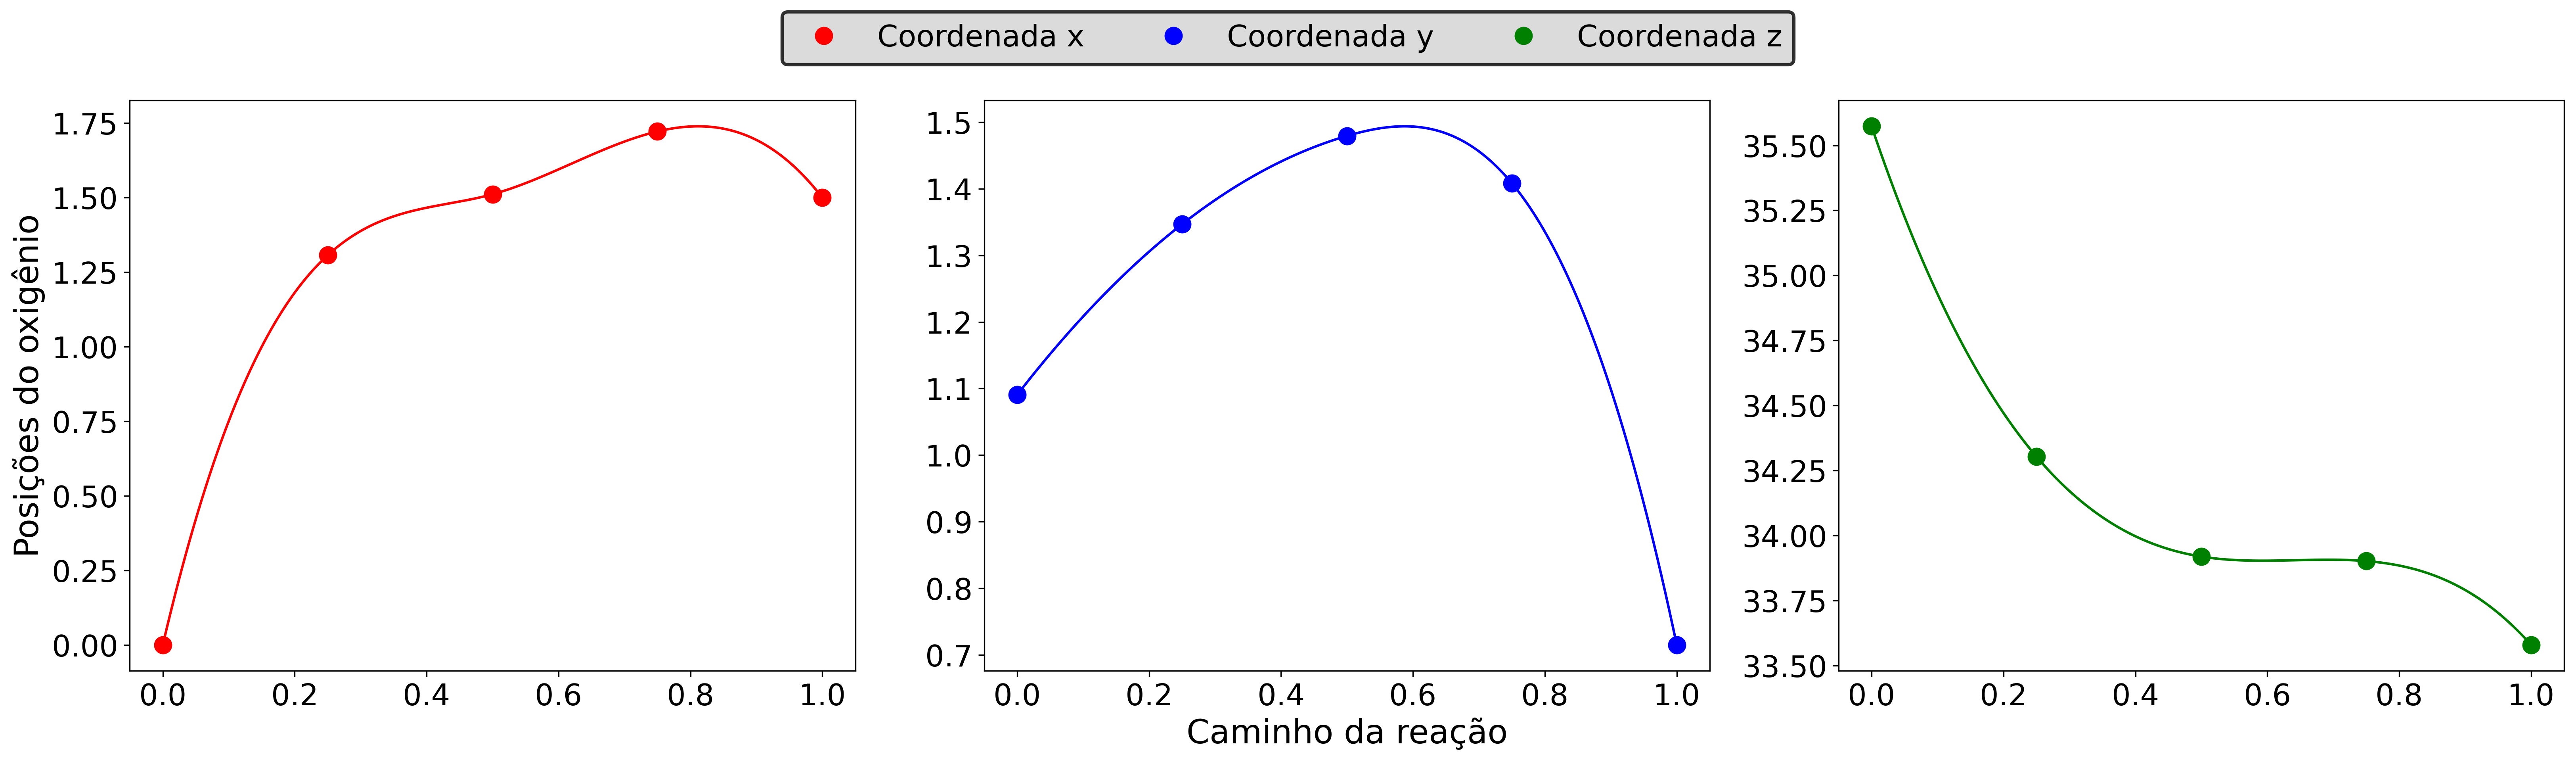

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 6), dpi=300)

ax[1].set_xlabel('Caminho da reação')
ax[0].set_ylabel('Posições do oxigênio')

ax[0].plot(qsi, atomsPositions[0][:, waterIndexes[0]], 'o', markersize=10, color='red', label='Coordenada x')
ax[0].plot(qsiInterpolation, atomsPositionsInterpolation[0][waterIndexes[0]], color='red')

ax[1].plot(qsi, atomsPositions[1][:, waterIndexes[0]], 'o', markersize=10, color='blue', label='Coordenada y')
ax[1].plot(qsiInterpolation, atomsPositionsInterpolation[1][waterIndexes[0]], color='blue')

ax[2].plot(qsi, atomsPositions[2][:, waterIndexes[0]], 'o', markersize=10, color='green', label='Coordenada z')
ax[2].plot(qsiInterpolation, atomsPositionsInterpolation[2][waterIndexes[0]], color='green')

legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3)
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.show()

## Interpolação das coordenadas dos átomos de hidrogênio

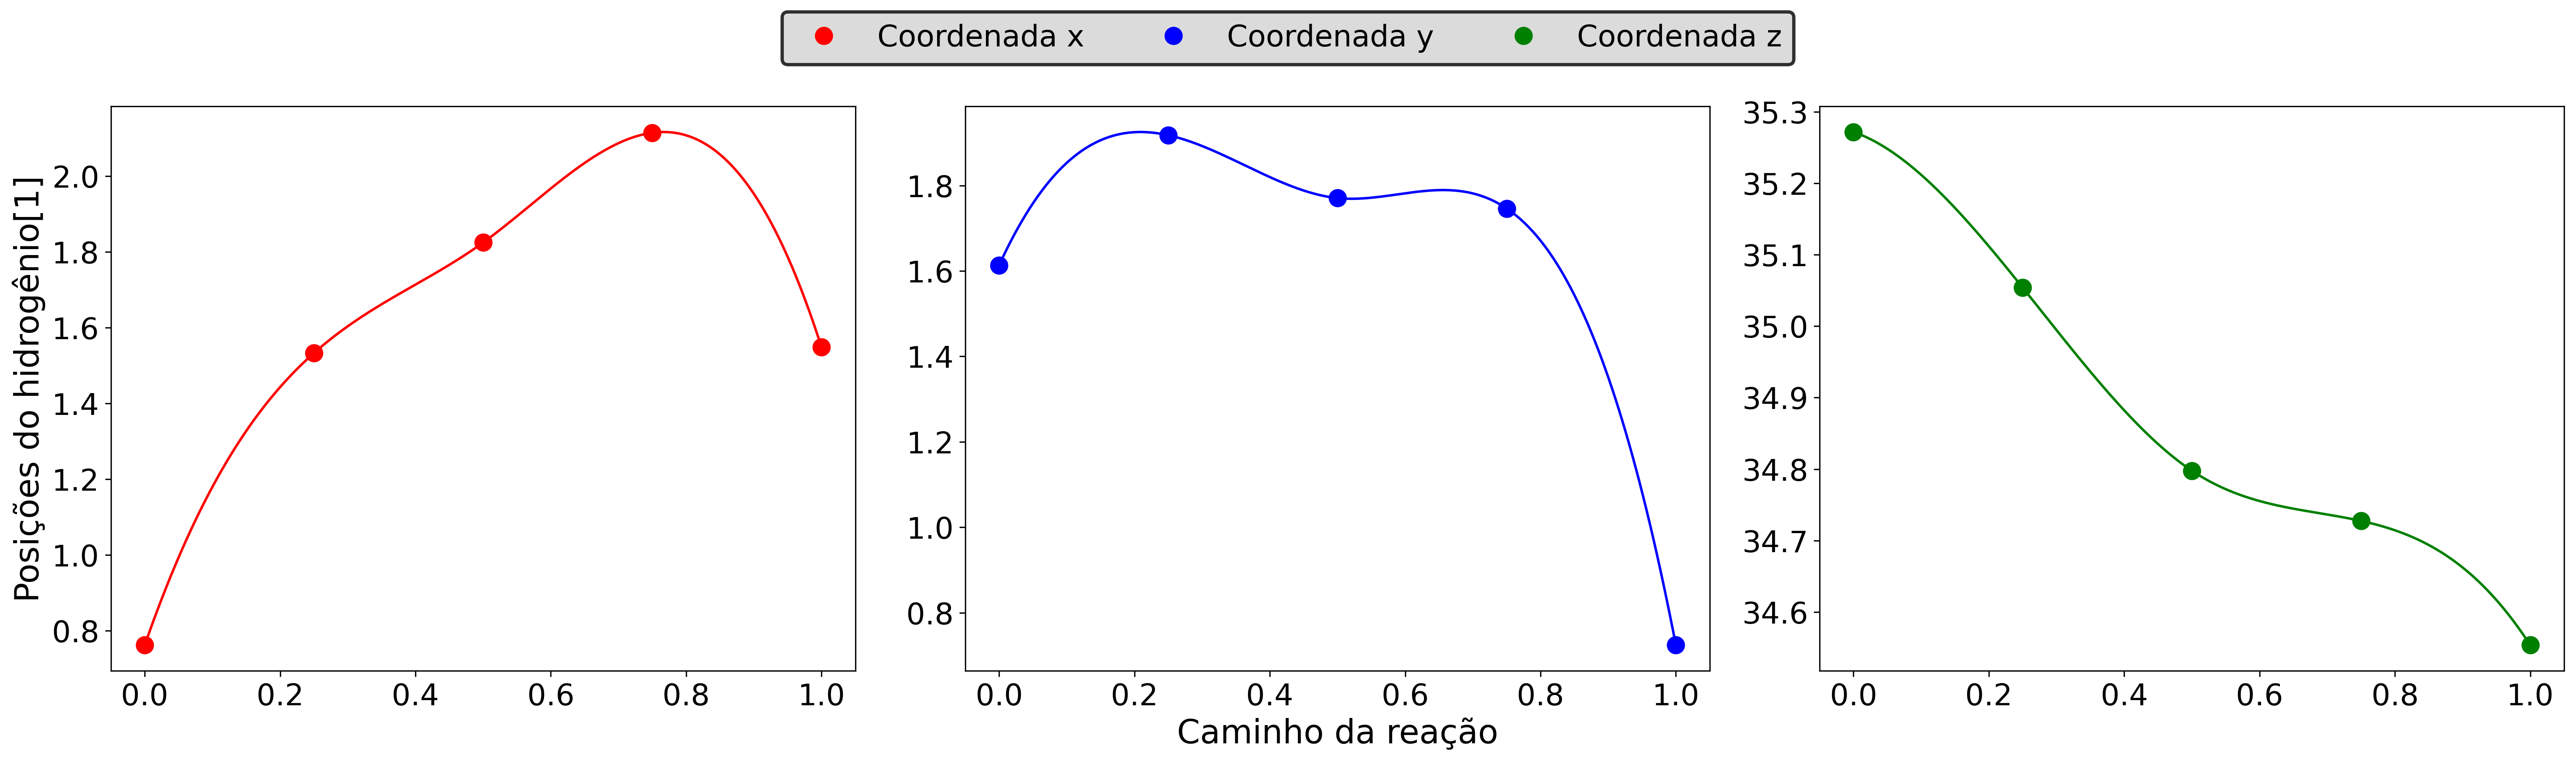

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 6), dpi=300)

ax[1].set_xlabel('Caminho da reação')
ax[0].set_ylabel('Posições do hidrogênio[1]')

ax[0].plot(qsi, atomsPositions[0][:, waterIndexes[1]], 'o', markersize=10, color='red', label='Coordenada x')
ax[0].plot(qsiInterpolation, atomsPositionsInterpolation[0][waterIndexes[1]], color='red')

ax[1].plot(qsi, atomsPositions[1][:, waterIndexes[1]], 'o', markersize=10, color='blue', label='Coordenada y')
ax[1].plot(qsiInterpolation, atomsPositionsInterpolation[1][waterIndexes[1]], color='blue')

ax[2].plot(qsi, atomsPositions[2][:, waterIndexes[1]], 'o', markersize=10, color='green', label='Coordenada z')
ax[2].plot(qsiInterpolation, atomsPositionsInterpolation[2][waterIndexes[1]], color='green')

legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3)
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.show()

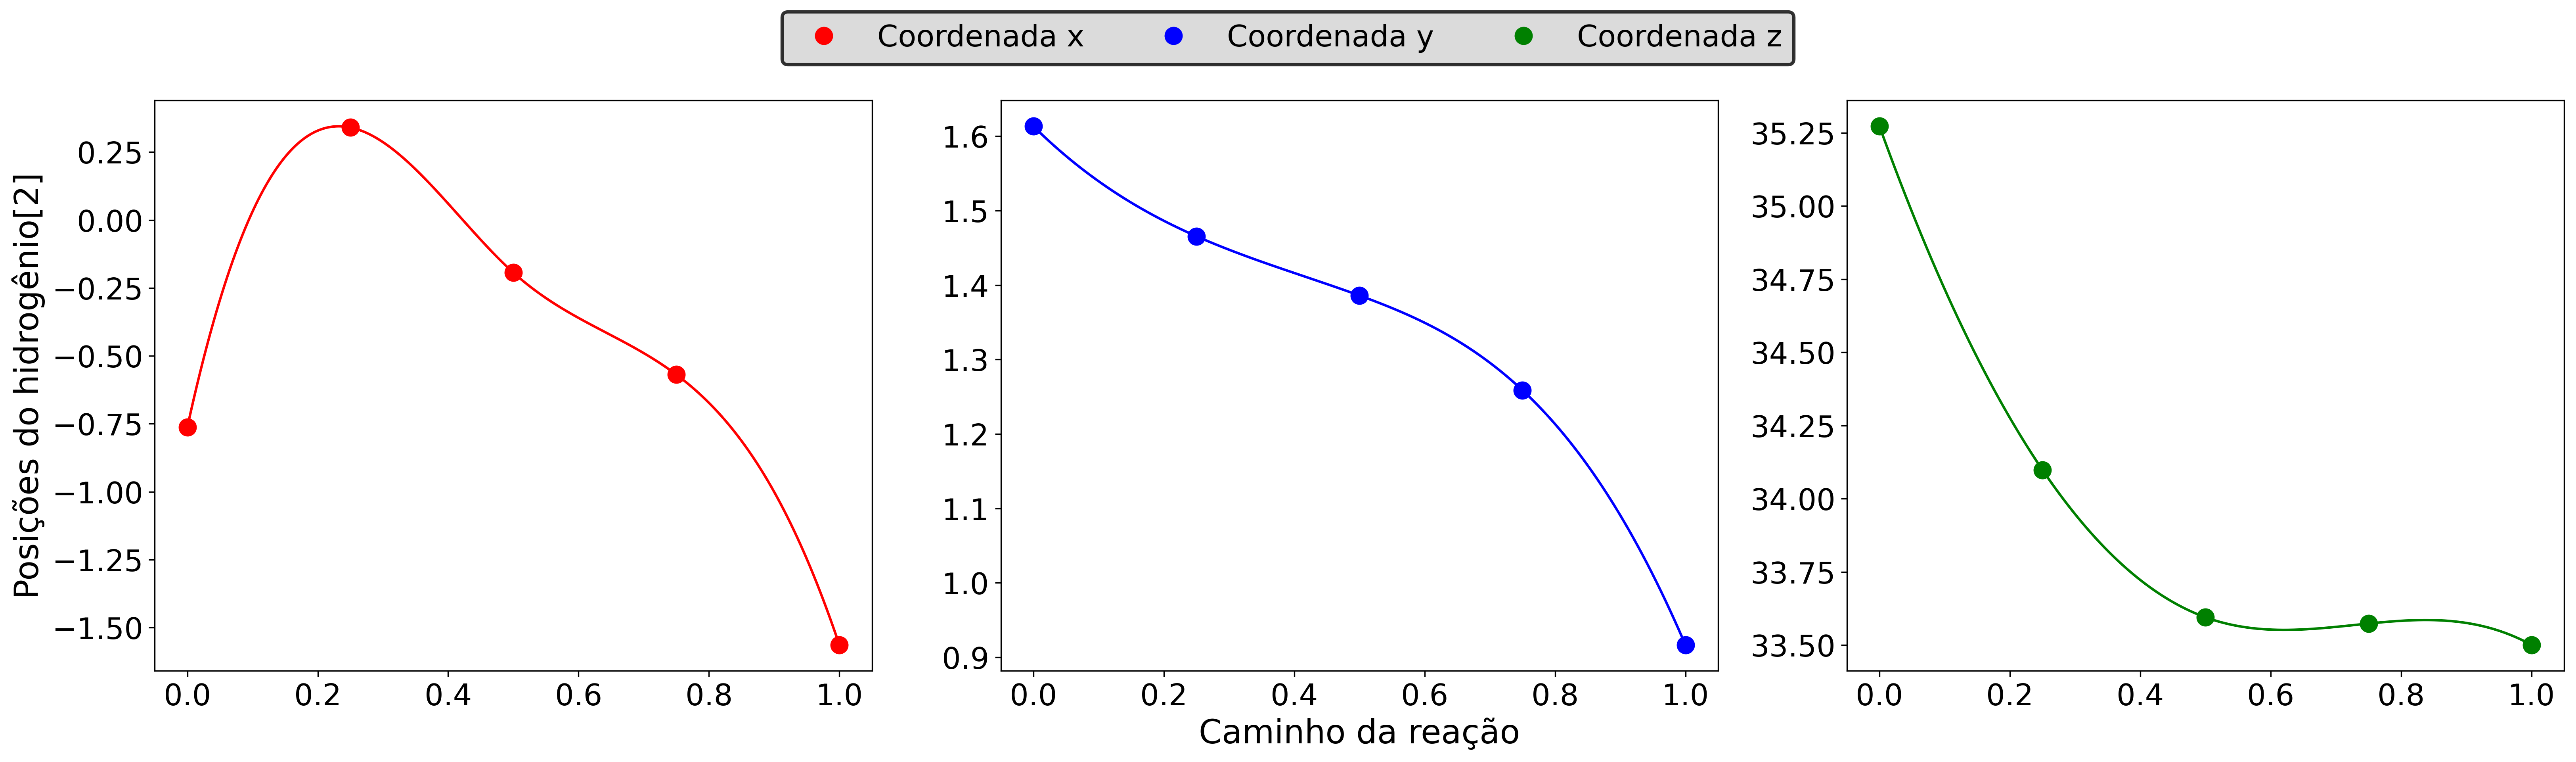

In [165]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 6), dpi=300)

ax[1].set_xlabel('Caminho da reação')
ax[0].set_ylabel('Posições do hidrogênio[2]')

ax[0].plot(qsi, atomsPositions[0][:, waterIndexes[2]], 'o', markersize=10, color='red', label='Coordenada x')
ax[0].plot(qsiInterpolation, atomsPositionsInterpolation[0][waterIndexes[2]], color='red')

ax[1].plot(qsi, atomsPositions[1][:, waterIndexes[2]], 'o', markersize=10, color='blue', label='Coordenada y')
ax[1].plot(qsiInterpolation, atomsPositionsInterpolation[1][waterIndexes[2]], color='blue')

ax[2].plot(qsi, atomsPositions[2][:, waterIndexes[2]], 'o', markersize=10, color='green', label='Coordenada z')
ax[2].plot(qsiInterpolation, atomsPositionsInterpolation[2][waterIndexes[2]], color='green')


legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3)
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.show()

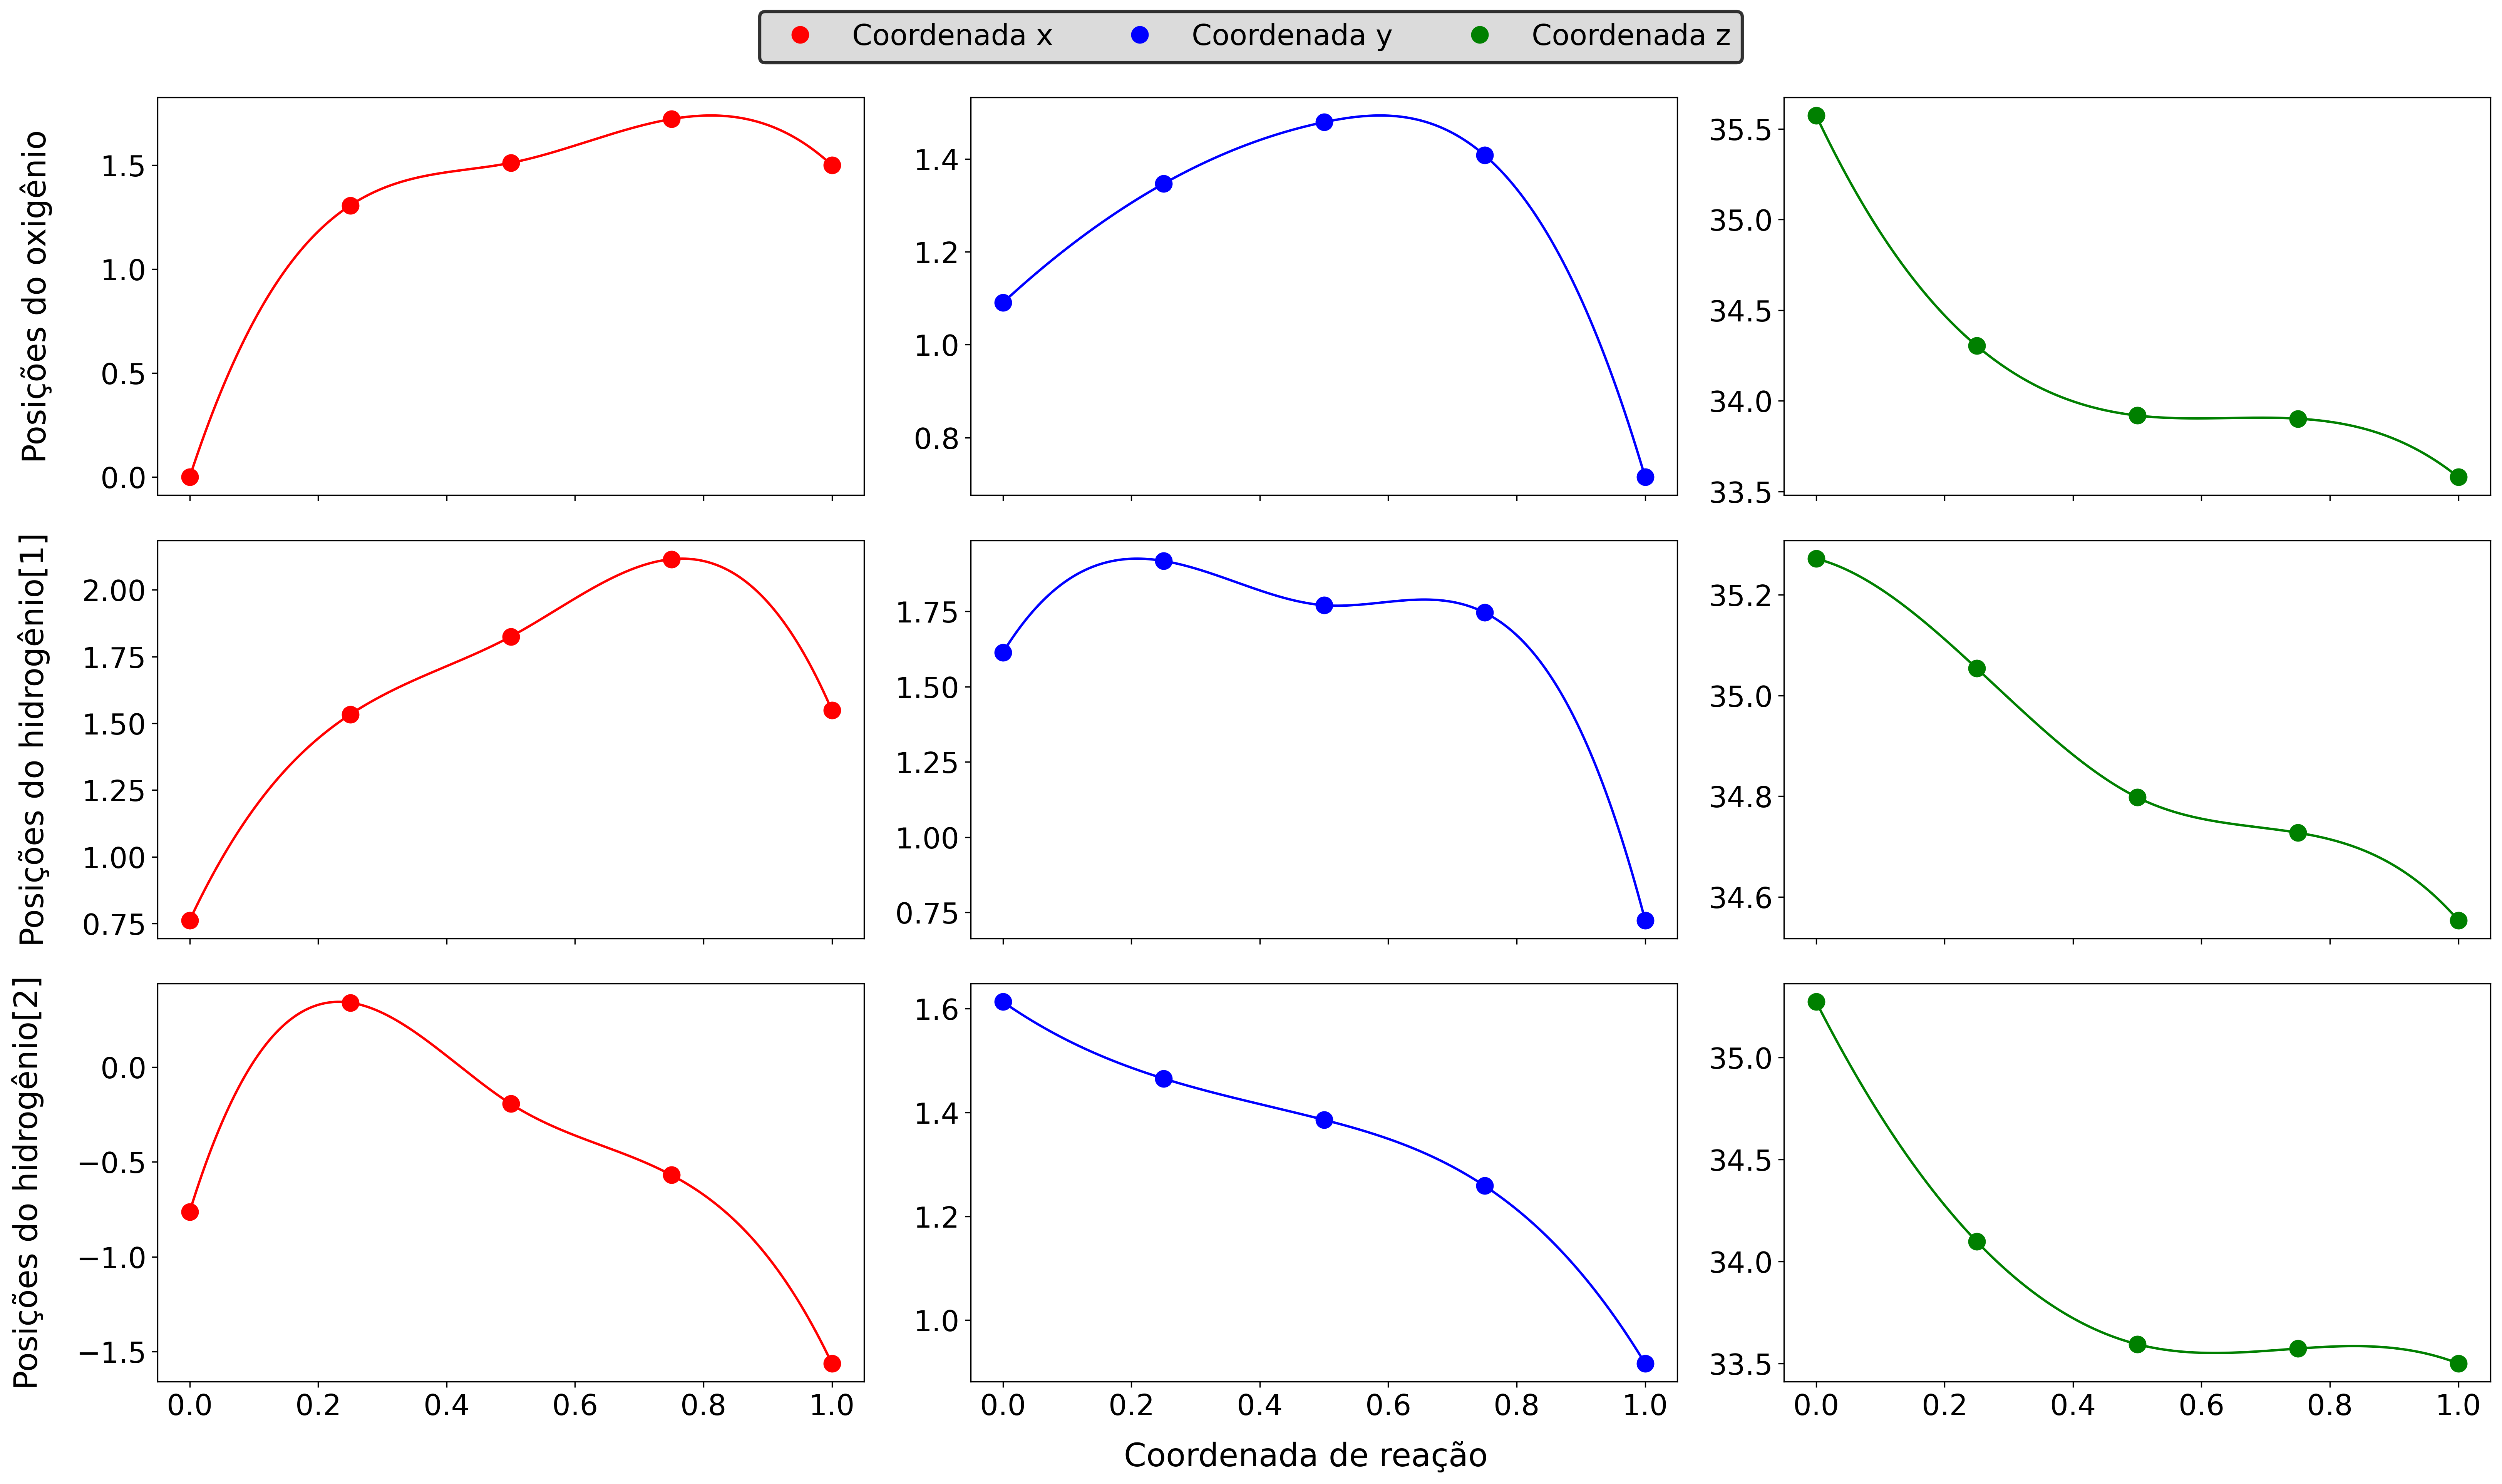

In [166]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 12), sharex=True, dpi=300)

# Oxigênio

ax[0][0].set_ylabel('Posições do oxigênio', labelpad=30)

ax[0][0].plot(qsi, atomsPositions[0][:, waterIndexes[0]], 'o', markersize=10, color='red', label='Coordenada x')
ax[0][0].plot(qsiInterpolation, atomsPositionsInterpolation[0][waterIndexes[0]], color='red')

ax[0][1].plot(qsi, atomsPositions[1][:, waterIndexes[0]], 'o', markersize=10, color='blue', label='Coordenada y')
ax[0][1].plot(qsiInterpolation, atomsPositionsInterpolation[1][waterIndexes[0]], color='blue')

ax[0][2].plot(qsi, atomsPositions[2][:, waterIndexes[0]], 'o', markersize=10, color='green', label='Coordenada z')
ax[0][2].plot(qsiInterpolation, atomsPositionsInterpolation[2][waterIndexes[0]], color='green')

# Hidrogênio 1

ax[1][0].set_ylabel('Posições do hidrogênio[1]', labelpad=20)

ax[1][0].plot(qsi, atomsPositions[0][:, waterIndexes[1]], 'o', markersize=10, color='red')
ax[1][0].plot(qsiInterpolation, atomsPositionsInterpolation[0][waterIndexes[1]], color='red')

ax[1][1].plot(qsi, atomsPositions[1][:, waterIndexes[1]], 'o', markersize=10, color='blue')
ax[1][1].plot(qsiInterpolation, atomsPositionsInterpolation[1][waterIndexes[1]], color='blue')

ax[1][2].plot(qsi, atomsPositions[2][:, waterIndexes[1]], 'o', markersize=10, color='green')
ax[1][2].plot(qsiInterpolation, atomsPositionsInterpolation[2][waterIndexes[1]], color='green')

# Hidrogênio 2

ax[2][0].set_ylabel('Posições do hidrogênio[2]', labelpad=20)

ax[2][0].plot(qsi, atomsPositions[0][:, waterIndexes[2]], 'o', markersize=10, color='red')
ax[2][0].plot(qsiInterpolation, atomsPositionsInterpolation[0][waterIndexes[2]], color='red')

ax[2][1].plot(qsi, atomsPositions[1][:, waterIndexes[2]], 'o', markersize=10, color='blue')
ax[2][1].plot(qsiInterpolation, atomsPositionsInterpolation[1][waterIndexes[2]], color='blue')

ax[2][2].plot(qsi, atomsPositions[2][:, waterIndexes[2]], 'o', markersize=10, color='green')
ax[2][2].plot(qsiInterpolation, atomsPositionsInterpolation[2][waterIndexes[2]], color='green')

# Legenda

fig.text(0.45, -0.01, 'Coordenada de reação', fontsize=20)

legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.show()

## Densidade ao longo do TTS

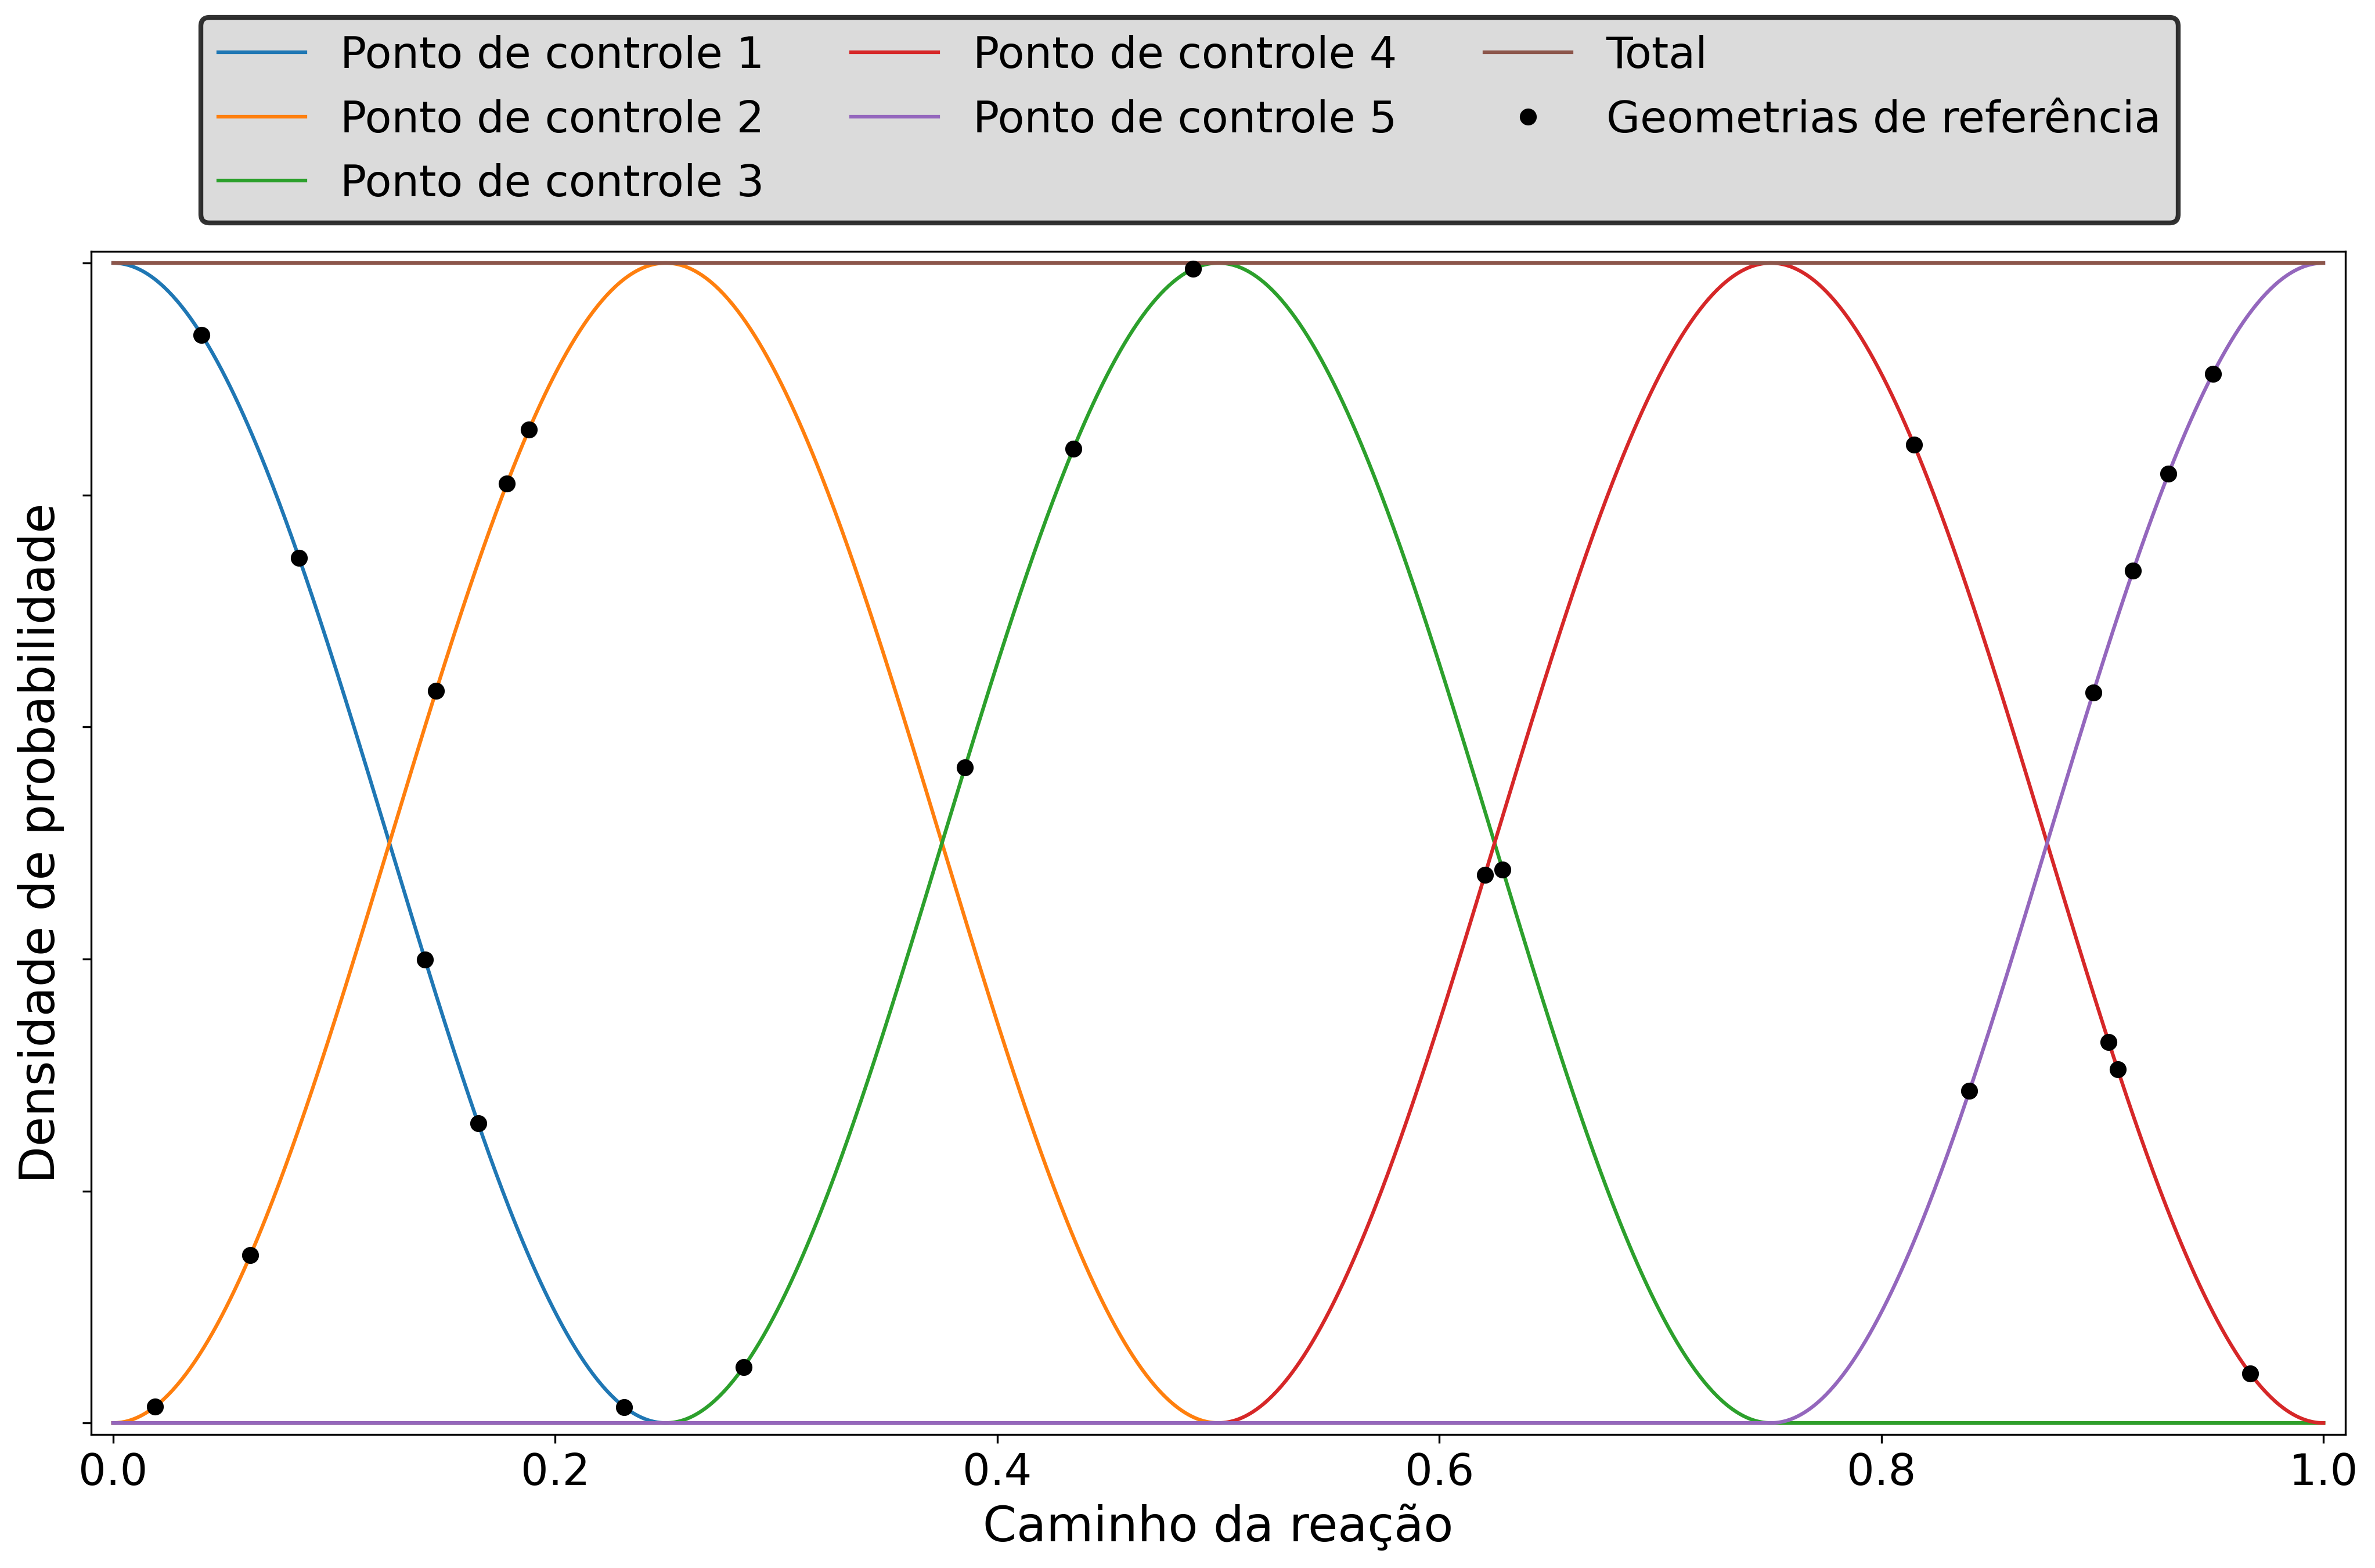

In [167]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), dpi=300)

# Curvas de densidade de probabilidade
ax.plot(qsiInterpolation, transitionTubeDensity[0], label='Ponto de controle 1')
ax.plot(qsiInterpolation, transitionTubeDensity[1], label='Ponto de controle 2')
ax.plot(qsiInterpolation, transitionTubeDensity[2], label='Ponto de controle 3')
ax.plot(qsiInterpolation, transitionTubeDensity[3], label='Ponto de controle 4')
ax.plot(qsiInterpolation, transitionTubeDensity[4], label='Ponto de controle 5')

# Curva da densidade de probabilidade total
total = transitionTubeDensity[0] + transitionTubeDensity[1] + transitionTubeDensity[2] + transitionTubeDensity[3] + transitionTubeDensity[4]
ax.plot(qsiInterpolation, total, label='Total')

# Pontos das geometrias de referência
ax.plot(firstDistributionXPoints, firstDistributionYPoints, 'o', color='black', label='Geometrias de referência')
ax.plot(secondDistributionXPoints, secondDistributionYPoints, 'o', color='black')
ax.plot(thirdDistributionXPoints, thirdDistributionYPoints, 'o', color='black')
ax.plot(fourthDistributionXPoints, fourthDistributionYPoints, 'o', color='black')
ax.plot(fifthDistributionXPoints, fifthDistributionYPoints, 'o', color='black')


ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)

ax.set_xlabel('Caminho da reação')
ax.set_ylabel('Densidade de probabilidade')

ax.set_yticklabels([])

legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.show()

In [46]:
dispersion = lambda a, b : 1 / (np.sqrt(a * (b ** 2)))

gaussian = lambda sigma, bins, mu: (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp( - (bins - mu)**2 / (2 * sigma**2) )

pontosGaussian = lambda beta, omega, omegao: np.exp(- 0.5 * beta * (omega ** 2) * (omegao ** 2))

In [48]:
mu_1, sigma_1 = 0, dispersion(beta(300), cm_to_ev(referenceGeometriesData[1][0][0]))
mu_2, sigma_2 = 0, dispersion(beta(300), cm_to_ev(referenceGeometriesData[1][0][1]))
mu_3, sigma_3 = 0, dispersion(beta(300), cm_to_ev(referenceGeometriesData[1][0][2]))

In [49]:
omega_1 = cm_to_ev(referenceGeometriesData[1][0][0])
omega_2 = cm_to_ev(referenceGeometriesData[1][0][1])
omega_3 = cm_to_ev(referenceGeometriesData[1][0][2])

omegao_1 = np.linalg.norm(referenceGeometriesData[2][0][0])
omegao_2 = np.linalg.norm(referenceGeometriesData[2][0][1])
omegao_3 = np.linalg.norm(referenceGeometriesData[2][0][2])

In [50]:
ponto_1 = pontosGaussian(beta(300), omega_1, omegao_1)
ponto_2 = pontosGaussian(beta(300), omega_2, omegao_2)
ponto_3 = pontosGaussian(beta(300), omega_3, omegao_3)

ponto_1, ponto_2, ponto_3

(0.8330198764681568, 0.0003056318581377464, 3.0439739008673227e-05)

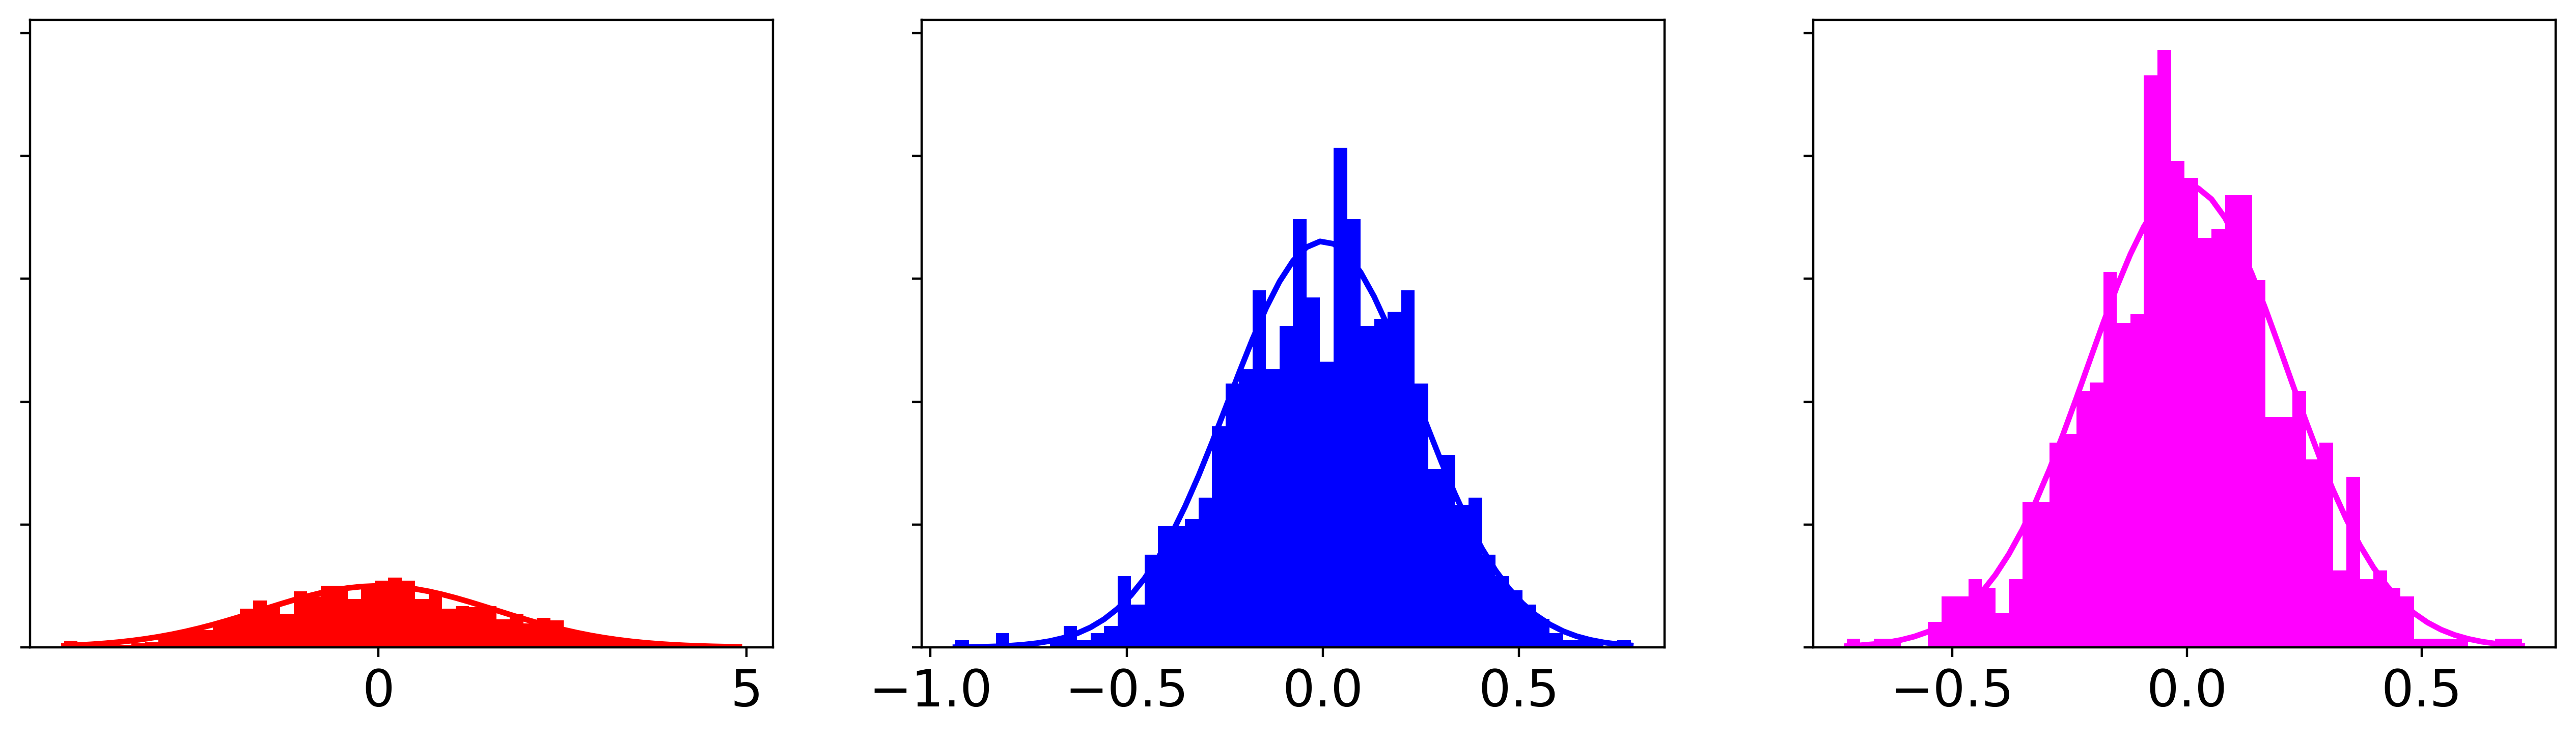

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), dpi=400, sharey=True)

[ ax[i].set_yticklabels([]) for i in range(3) ]

gaussiana_1_numpy = np.random.normal(mu_1, sigma_1, 1000)
gaussiana_2_numpy = np.random.normal(mu_2, sigma_2, 1000)
gaussiana_3_numpy = np.random.normal(mu_3, sigma_3, 1000)

count_1, bins_1, ignored_1 = ax[0].hist(gaussiana_1_numpy, 50, density=True, color='red')
count_2, bins_2, ignored_2 = ax[1].hist(gaussiana_2_numpy, 50, density=True, color = 'blue')
count_3, bins_3, ignored_3 = ax[2].hist(gaussiana_3_numpy, 50, density=True, color='magenta')

gaussiana_1_analitica = gaussian(sigma_1, bins_1, mu_1)
gaussiana_2_analitica = gaussian(sigma_2, bins_2, mu_2)
gaussiana_3_analitica = gaussian(sigma_3, bins_3, mu_3)

ax[0].plot(bins_1, gaussiana_1_analitica, linewidth=2, color='red')
ax[1].plot(bins_2, gaussiana_2_analitica, linewidth=2, color='blue')
ax[2].plot(bins_3, gaussiana_3_analitica, linewidth=2, color='magenta')

plt.show()

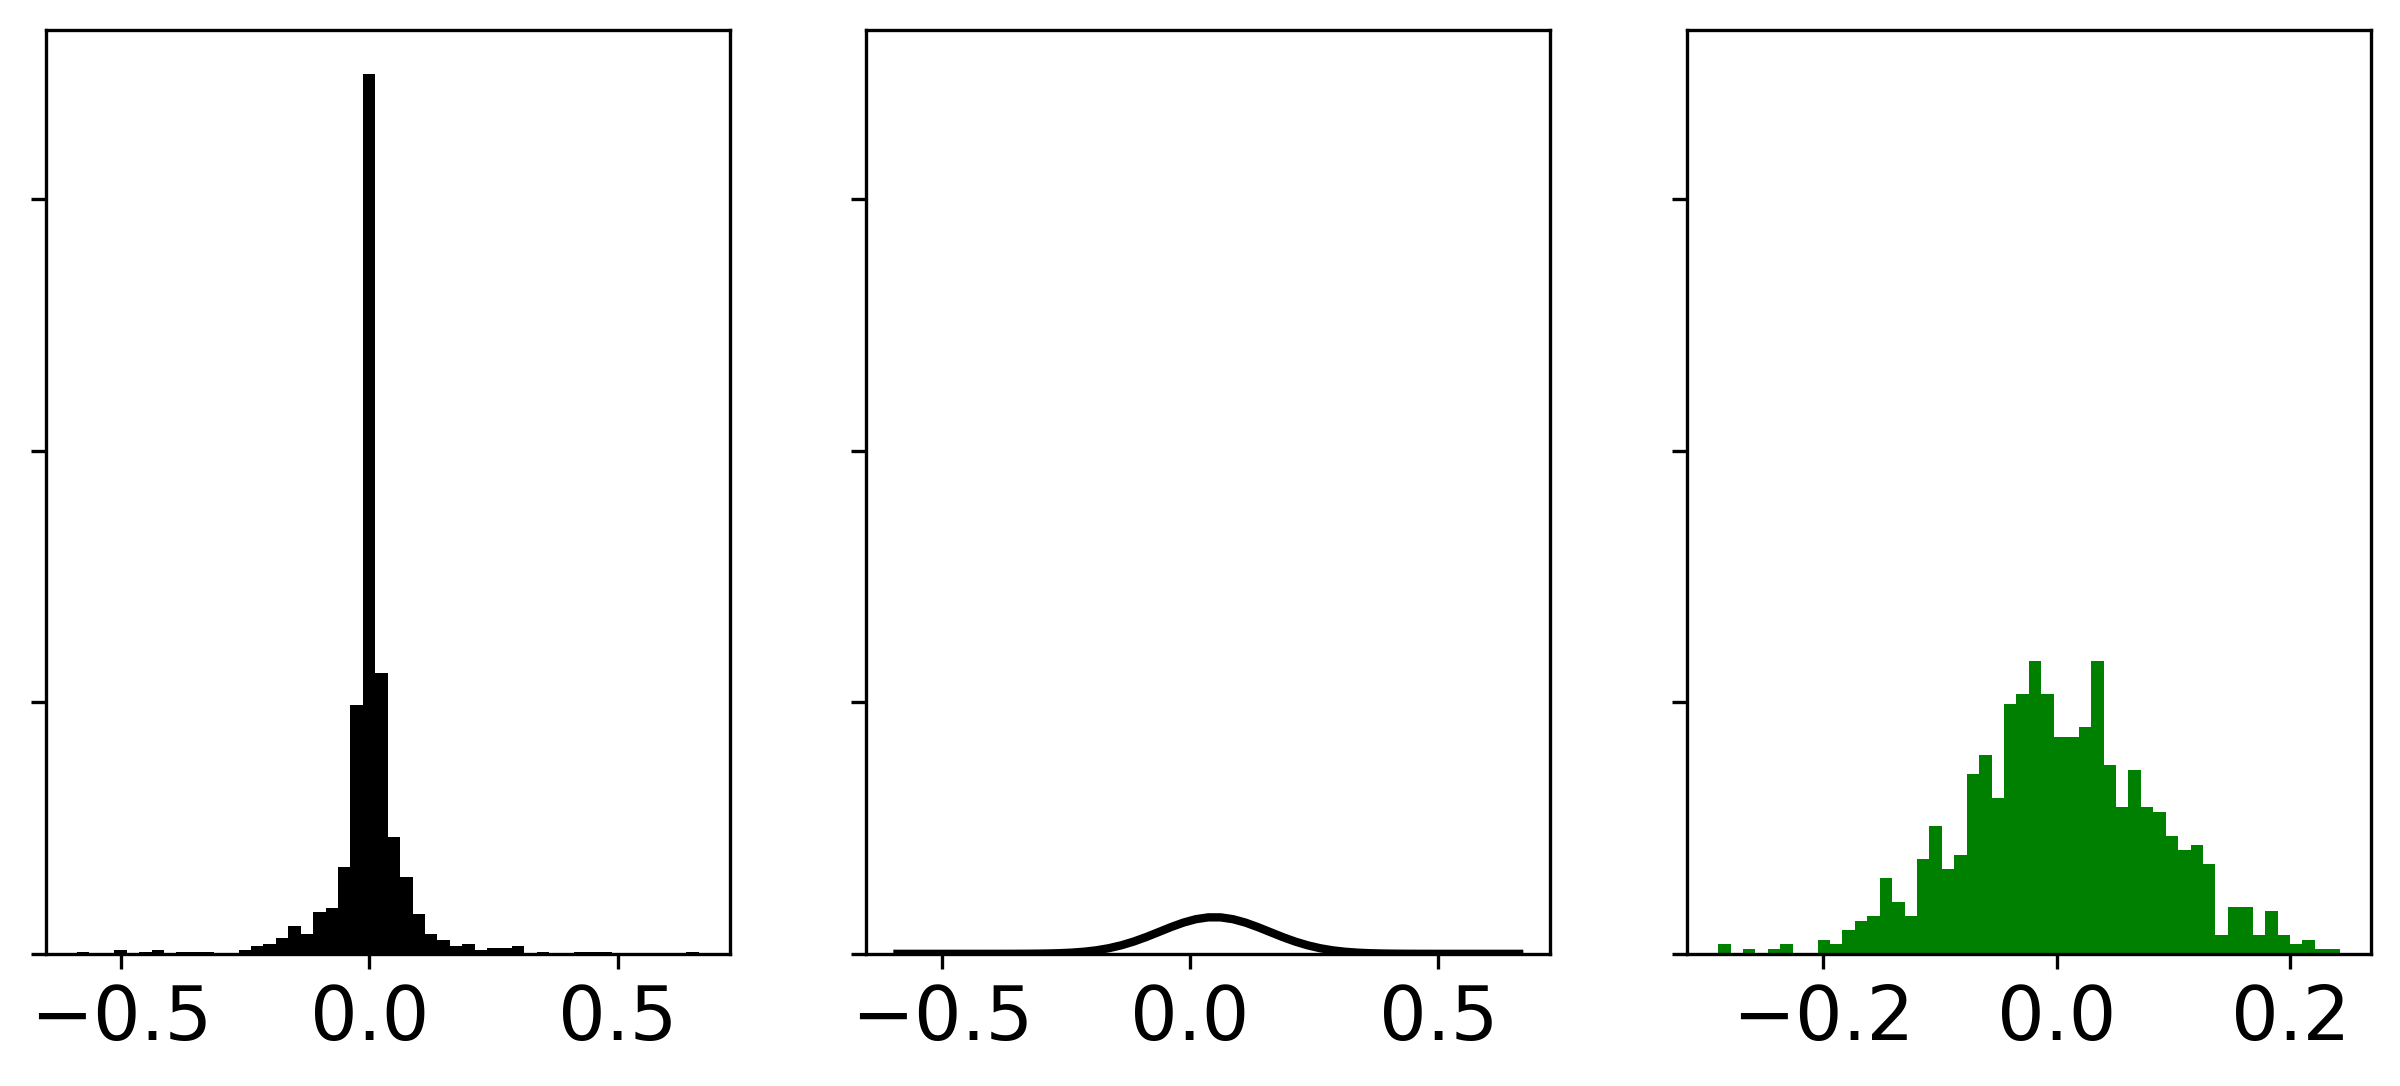

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=300, sharey=True)

[ ax[i].set_yticklabels([]) for i in range(3) ]

gaussiana_analitica_final = np.multiply(np.multiply(gaussiana_1_analitica, gaussiana_2_analitica), gaussiana_3_analitica)
gaussiana_numpy_final = np.multiply(np.multiply(gaussiana_1_numpy, gaussiana_2_numpy), gaussiana_3_numpy)
outra_gaussiana_numpy = np.random.normal(mu_1 * mu_2 * mu_3, sigma_1 * sigma_2 * sigma_3, 1000)


count, bins, ignored = ax[0].hist(gaussiana_numpy_final, 50, density=True, color='black')
ax[1].plot(bins, gaussiana_analitica_final, linewidth=2, color='black')
count, bins, ignored = ax[2].hist(outra_gaussiana_numpy, 50, density=True, color='green')

plt.show()